In [ ]:
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

from ukbb_recessive.regression.regressions import read_results_excel
import ukbb_recessive.regression.plotting as plotting


sns.set_style("whitegrid")

import matplotlib

from matplotlib import font_manager
import numpy as np
from matplotlib.cm import get_cmap

import glob

import matplotlib.ticker as ticker


# Add fonts
plotting.add_fonts(['../../../data/fonts'])
plotting.configure_matplotlib()

PLOTS_OUTPUT_DIR = '../../../data/plots/extended_figures'

tables_folder = '../../../data/tables'

# Extended figure 1 (Childlessness for other s-het sources)

In [2]:
tables_folder = '../../../data/tables'
output_folder = '../../../data/plots'
all_s_hets =['Roulette', 'Weghorn', 'Cassa', 'pLI']

results_path = f"{tables_folder}/table_selection_analysis.xlsx"

# load flat table
childlessness = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect
childlessness = childlessness[childlessness['feature'].str.contains("s_het")]

# add odds ratio distance
childlessness = plotting.add_odds_ratio_intervals(childlessness)

In [3]:
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'childlessness': 'Childlessness'
}

# select targets of interest
childlessness = childlessness[childlessness['target'].isin(renaming_dict_target.keys())].copy()
childlessness['target'] = childlessness['target'].apply(lambda x: renaming_dict_target.get(x, x))

# select gender of interest
childlessness = childlessness[childlessness['gender'] == 'all']

# select analyses
renaming_dict_analyses = {
    'selection regressions on [s_het_recessive_all]' : 'PLPs in recessive genes',
    'selection regressions on [s_het_lof_without_AR]' : 'Singleton LoFs in non-recessive genes',
    'exlude_lof_carriers regressions on [s_het_recessive_all]' : 'PLPs in recessive genes w/out LoF carriers'
}

childlessness = childlessness[childlessness['analysis'].isin(renaming_dict_analyses.keys())].copy()
childlessness['analysis'] = childlessness['analysis'].apply(lambda x: renaming_dict_analyses.get(x, x))

childlessness.head(3)

dataset              feature    effect  odds_ratio  odds_ratio_lower  \
24    Cassa  s_het_recessive_all  0.693995    2.001696          1.161002   
25      pLI  s_het_recessive_all  0.127739    1.136257          1.036840   
26  Weghorn  s_het_recessive_all  0.605141    1.831510          1.166799   

    odds_ratio_upper odds_ratio_pretty        99.0% CI   p_value  \
24          3.451148        OR = 2.002  [1.161, 3.451]  0.001032   
25          1.245206        OR = 1.136  [1.037, 1.245]  0.000326   
26          2.874898        OR = 1.832  [1.167, 2.875]  0.000546   

    p_value_corrected  ...  n_observations         target gender  \
24           0.010316  ...          353246  Childlessness    all   
25           0.003262  ...          337479  Childlessness    all   
26           0.005460  ...          353425  Childlessness    all   

                   analysis  \
24  PLPs in recessive genes   
25  PLPs in recessive genes   
26  PLPs in recessive genes   

                                              formula    family  \
24  childlessness ~ s_het_recessive_all + age_at_r...  binomial   
25  childlessness ~ s_het_recessive_all + age_at_r...  binomial   
26  childlessness ~ s_het_recessive_all + age_at_r...  binomial   

   p_value_pretty p_value_corrected_pretty odds_ratio_lower_distance  \
24      1.03×10⁻³                     0.01                  0.840695   
25      3.26×10⁻⁴                3.26×10⁻³                  0.099417   
26      5.46×10⁻⁴                5.46×10⁻³                  0.664711   

    odds_ratio_upper_distance  
24                   1.449451  
25                   0.108950  
26                   1.043388  

[3 rows x 21 columns]

In [4]:
def plot_3_ext(ax, s_het_tag, text_pos):

    y_order = ['Childlessness', 'Hair color']
    group_order = ['Singleton LoFs in non-recessive genes', 'PLPs in recessive genes w/out LoF carriers', 'PLPs in recessive genes'][::-1]

    legend_kwargs = {
        "bbox_to_anchor": (0.0, 1., 1, .102), 
        "frameon": False,
        "mode": "expand", 
        "ncol": 1, 
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }

    # colors=['#B048B5', '#046307', '#FFAE42']
    colors=['#B048B5',  '#FF8225', '#046307',]

    plotted_data = plotting.plot_errorbar_grouped(df=childlessness[childlessness['dataset'] == s_het_tag].copy(), 
                                        axis=ax, y_column='target', group_column = 'analysis',  
                                        legend_loc='upper left', 
                                        legend_kwargs=legend_kwargs,
                                        group_scale=0.02, 
                                        y_scale=0.08,
                                        colors=colors,
                                        y_order=y_order, 
                                        group_order=group_order
                                        )


    plotting.configure_axis(ax, x_label='OR (99% CI)', y_label=None, format_x=True, ymargin=0.12,)

    # Display p-values or any other information in the sidebar
    p_values = plotted_data['p_value_corrected_pretty']
    or_values = plotted_data['odds_ratio']
    positions = plotted_data['y']


    for i, (p, oddsr, pos) in enumerate(zip(p_values, or_values, positions)):
        ax.text(text_pos, pos+0.01, f'{oddsr:.2f}   {p}', va='center', size=plotting.MEDIUM_SIZE)


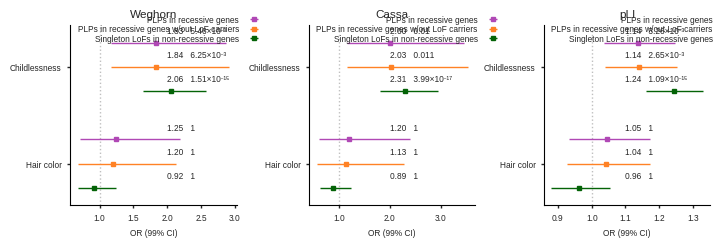

In [5]:
cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 6*cm*k))

axes = fig.subplots(1, 3)

plot_3_ext(axes[0], 'Weghorn', text_pos=2)
axes[0].set_title('Weghorn')

plot_3_ext(axes[1], 'Cassa', text_pos=2)
axes[1].set_title('Cassa')

plot_3_ext(axes[2], 'pLI', text_pos=1.1)
axes[2].set_title('pLI')


plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_1.pdf", format="pdf", bbox_inches="tight")

# Extended figure 2 (cohort downsamling)

In [6]:
# samples of interest: European & non-related
european_non_rel_samples = ".../450k/samples/european_non_related_no_withdrawal_to_include_450k.no_hom_comp_het.txt"

european_non_rel_samples = set(pd.read_csv(european_non_rel_samples, header=None)[0].values.tolist())
print ("Number of samples:", len(european_non_rel_samples))

Number of samples: 376608


In [7]:
tables_folder = '../../../data/tables'

recessive_df = read_results_excel(f"{tables_folder}/sampling/dataset/table_dataset_sampling_regressions_on_[s_het_recessive_all].xlsx", 
                                  flatten_multiindex=True)
recessive_df['dataset'] = 'PLPs in recessive genes'

lof_df = read_results_excel(f"{tables_folder}/sampling/dataset/table_dataset_sampling_regressions_on_[s_het_lof_without_AR].xlsx", 
                            flatten_multiindex=True)
lof_df['dataset'] = 'Singleton LoFs in non-recessive highly constrained genes'

data = pd.concat([recessive_df, lof_df])

# leave only necessary s_het effect
data = data[data['feature'].str.contains("s_het")]

# add odds ratio distance
data = plotting.add_odds_ratio_intervals(data)
data = plotting.add_effect_size_intervals(data)
data['sample_size'] = (data['analysis'].str.split('=', expand=True)[1].astype(float)*len(european_non_rel_samples)).astype(int)
data['p_value_corrected'] = (data['p_value'] * 10).apply(lambda x: 1 if x > 1 else x)

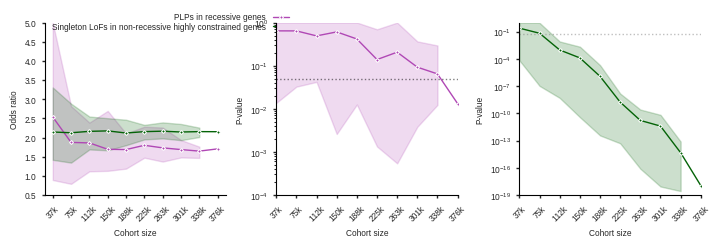

In [8]:
cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 6*cm*k))

ticks = data['sample_size'].unique()
tick_labels = [f"{int(x/1000)}k" for x in ticks]

axes = fig.subplots(1, 3)

colors=['#B048B5',  '#046307',]

# plot odd ratios
sns.lineplot(data=data, x='sample_size', y='odds_ratio', palette=colors,
             marker="D", hue='dataset', errorbar=('pi', 99), 
             linewidth=1, markersize=2, ax=axes[0])

plotting.configure_axis(axes[0], x_label='Cohort size', y_label='Odds ratio', ylim=(0.5,5))

axes[0].set_xticks(ticks)
axes[0].set_xticklabels(ticks)
axes[0].set_xticklabels(tick_labels, rotation=45)
axes[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1., 1, .102), frameon=False, 
               mode="expand", ncol=1, labelspacing=0.1, markerfirst=False, fontsize=plotting.MEDIUM_SIZE)

# plot PLP in recessive genes

sns.lineplot(data=data[data['dataset'].str.contains('PLP')], x='sample_size', y='p_value_corrected', 
             marker="D", errorbar=('pi', 99), 
             linewidth=1, markersize=2, ax=axes[1], legend=None, color='#B048B5')

axes[1].axhline(y=0.05, color='k', linestyle='dotted', linewidth=1, alpha=0.5)

axes[1].set_yscale('log')

plotting.configure_axis(axes[1], x_label='Cohort size', y_label='P-value', ylim = (0.0001, 1), xlim=[ticks[0], ticks[-1]])
axes[1].set_xticks(ticks)
axes[1].set_xticklabels(tick_labels, rotation=45)

# plot LoFs in recessive genes

sns.lineplot(data=data[data['dataset'].str.contains('LoF')], x='sample_size', y='p_value_corrected', 
             marker="D", errorbar=('pi', 99), 
             linewidth=1, markersize=2, ax=axes[2], legend=None, color='#046307')

axes[2].axhline(y=0.05, color='gray', linestyle='dotted', linewidth=1, alpha=0.5)

axes[2].set_yscale('log')

plotting.configure_axis(axes[2], x_label='Cohort size', y_label='P-value', ylim = (1e-19, 1), xlim=[ticks[0], ticks[-1]])
axes[2].set_xticks(ticks)
axes[2].set_xticklabels(tick_labels, rotation=45)

plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_2.pdf", format="pdf", bbox_inches="tight")

# Extended figure 3 (other phenotypes for other s-het sources)

In [9]:
tables_folder = '../../../data/tables'

results_path = f"{tables_folder}/table_phenotype_analysis.xlsx"

# load flat table
phenotypes = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect
phenotypes = phenotypes[phenotypes['feature'].str.contains("s_het")]

# add odds ratio distance
phenotypes = plotting.add_odds_ratio_intervals(phenotypes)
phenotypes = plotting.add_effect_size_intervals(phenotypes)

In [10]:
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'years_of_edu': 'Years of\neducation',
    'diagnosis_total_ICD10_cnt_log': 'Diagnoses\ncount (log)',
    'ICD_infertility': 'Infertility',
    'living_with_a_partner': 'Has partner',
    'fluid_intelligence_score': 'Fluid\nintelligence',
    'childlessness': 'Childlessness'
}

# select targets of interest
phenotypes = phenotypes[phenotypes['target'].isin(renaming_dict_target.keys())].copy()
phenotypes['target'] = phenotypes['target'].apply(lambda x: renaming_dict_target.get(x, x))

# select gender of interest
phenotypes = phenotypes[phenotypes['gender'] == 'all']

# select analyses
renaming_dict_analyses = {
    'phenotype regressions on [s_het_recessive_all]' : 'PLPs in recessive genes',
    'phenotype regressions on [s_het_lof_without_AR]' : 'Singleton LoFs in non-recessive genes'
}

phenotypes = phenotypes[phenotypes['analysis'].isin(renaming_dict_analyses.keys())].copy()
phenotypes['analysis'] = phenotypes['analysis'].apply(lambda x: renaming_dict_analyses.get(x, x))

phenotypes.head(3)

dataset              feature    effect  odds_ratio  odds_ratio_lower  \
0    Cassa  s_het_recessive_all  0.693995    2.001696          1.161002   
1      pLI  s_het_recessive_all  0.127739    1.136257          1.036840   
2  Weghorn  s_het_recessive_all  0.605141    1.831510          1.166799   

   odds_ratio_upper odds_ratio_pretty        99.0% CI   p_value  \
0          3.451148        OR = 2.002  [1.161, 3.451]  0.001032   
1          1.245206        OR = 1.136  [1.037, 1.245]  0.000326   
2          2.874898        OR = 1.832  [1.167, 2.875]  0.000546   

   p_value_corrected  ...  gender                 analysis  \
0           0.010316  ...     all  PLPs in recessive genes   
1           0.003262  ...     all  PLPs in recessive genes   
2           0.005460  ...     all  PLPs in recessive genes   

                                             formula    family p_value_pretty  \
0  childlessness ~ s_het_recessive_all + age_at_r...  binomial      1.03×10⁻³   
1  childlessness ~ s_het_recessive_all + age_at_r...  binomial      3.26×10⁻⁴   
2  childlessness ~ s_het_recessive_all + age_at_r...  binomial      5.46×10⁻⁴   

  p_value_corrected_pretty odds_ratio_lower_distance  \
0                     0.01                  0.840695   
1                3.26×10⁻³                  0.099417   
2                5.46×10⁻³                  0.664711   

  odds_ratio_upper_distance effect_lower_distance  effect_upper_distance  
0                  1.449451              0.544712               0.544712  
1                  0.108950              0.091562               0.091562  
2                  1.043388              0.450877               0.450877  

[3 rows x 23 columns]

In [11]:
def format_thousands(x):
    return f'{x:,.0f}'  # Use , as a thousand separator and format as integers

def plot_phenotype(ax, y_order, dataset, plot_entity='odds_ratio', legend_loc='upper left'):

    group_order = ['Singleton LoFs in non-recessive genes', 'PLPs in recessive genes'][::-1]

    legend_kwargs = {
        "bbox_to_anchor": (0.0, 1., 1, .102), 
        "frameon": False,
        "mode": "expand", 
        "ncol": 1, 
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }

    colors=['#B048B5', '#046307',]

    vline_loc = 1 if plot_entity == 'odds_ratio' else 0

    plotted_data = plotting.plot_errorbar_grouped(df=phenotypes[phenotypes['target'].isin(y_order) & (phenotypes['dataset'] == dataset)].copy(), 
                                        axis=ax, y_column='target', group_column = 'analysis',  
                                        legend_loc=legend_loc, 
                                        legend_kwargs=legend_kwargs,
                                        group_scale=0.03, 
                                        y_scale=0.1,
                                        colors=colors,
                                        y_order=y_order, 
                                        group_order=group_order, 
                                        plot_entity=plot_entity, 
                                        vertical_loc=vline_loc, 
                                        horizontal=False)


    # plotting.configure_axis(ax, x_label='Odds ratio (99% CI)', y_label=None, ymargin=0.12)

    # Display p-values or any other information in the sidebar
    p_values = plotted_data['p_value_corrected_pretty']
    or_values = plotted_data[plot_entity] 
    positions = plotted_data['y']

    plot_loc = plotted_data[f'{plot_entity}'] - plotted_data[f'{plot_entity}_lower_distance']

    for i, (loc, p, oddsr, pos) in enumerate(zip(plot_loc, p_values, or_values, positions)):
        ax.text(loc, pos+0.005, f'{round(oddsr, 2)}   {p}', va='center', size=plotting.MEDIUM_SIZE)


ticks_config = {
    'Weghorn': [
            [-3, -2, -1, 0], 
            [-1.5, -1.0, -0.5, 0.0],
            [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        ], 

    'Cassa': [
            [-3, -2, -1, 0], 
            [-2.0, -1.5, -1.0, -0.5, 0.0],
            [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        ], 

    'pLI': [
            [ -1, -0.8, -0.6, -0.4, -0.2, 0], 
            [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0],
            [0.0, 0.05, 0.1, 0.15, 0.2]
        ], 
}

xlim_config = {
    'Weghorn': [(-3.2, 0.2), (-1.6, 0.1), (-0.08, 0.55)],
    'Cassa': [None, (-2, 0.1), (-0.01, 0.6)],
    'pLI': [(-1, 0.1), (-0.56, 0.056), (-0.01, 0.2)]
}

def plot_phenotypes(subfig, dataset):
    ticks = ticks_config[dataset]
    xlim = xlim_config[dataset]

    # plot phenotypes results
    ax_left = subfig.subplots(3, 1)

    # years of education
    plot_phenotype(ax_left[0], y_order=['Years of\neducation'], plot_entity='effect', legend_loc=None, dataset=dataset)
    plotting.configure_axis(ax_left[0], xlim=xlim[0], x_label='Effect size',  ymargin=1, format_x=True)
    ax_left[0].set_xticks(ticks[0])
    ax_left[0].set_xticklabels(ticks[0])

    # fluid intelligence
    plot_phenotype(ax_left[1], y_order=['Fluid\nintelligence'], plot_entity='effect',legend_loc=None, dataset=dataset)
    plotting.configure_axis(ax_left[1], xlim=xlim[1], x_label='Effect size',  ymargin=1, format_x=True)
    ax_left[1].set_xticks(ticks[1])
    ax_left[1].set_xticklabels(ticks[1])

    # diagnoses count
    plot_phenotype(ax_left[2], y_order=['Diagnoses\ncount (log)'], plot_entity='effect', legend_loc=None, dataset=dataset)
    plotting.configure_axis(ax_left[2], xlim=xlim[2], x_label='Effect size',  ymargin=1, format_x=True)
    ax_left[2].set_xticks(ticks[2])
    ax_left[2].set_xticklabels(ticks[2])

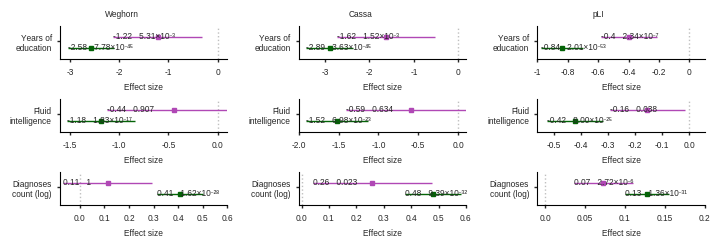

In [12]:
cm = 1/2.54  # centimeters in inches
k = 1.
fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 6*cm*k))

# divide subfigure into left and right parts
subfigs = fig.subfigures(nrows=1, ncols=3, width_ratios=[1, 1, 1], wspace=0.03)

plot_phenotypes(subfigs[0], 'Weghorn')
subfigs[0].suptitle('Weghorn', fontsize=plotting.MEDIUM_SIZE)

plot_phenotypes(subfigs[1], 'Cassa')
subfigs[1].suptitle('Cassa', fontsize=plotting.MEDIUM_SIZE)

plot_phenotypes(subfigs[2], 'pLI')
subfigs[2].suptitle('pLI', fontsize=plotting.MEDIUM_SIZE)

plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_3.pdf", format="pdf", bbox_inches="tight")

# Extended Figure 4 (ID vs rest)

In [13]:
results_path = f"{tables_folder}/table_id_vs_rest_analysis.xlsx"

# load flat table
id_vs_rest = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect
id_vs_rest = id_vs_rest[id_vs_rest['feature'].str.contains("s_het")]

# add odds ratio distance
id_vs_rest = plotting.add_odds_ratio_intervals(id_vs_rest)
id_vs_rest = plotting.add_effect_size_intervals(id_vs_rest)

In [14]:
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'years_of_edu': 'Years of\neducation',
    'diagnosis_total_ICD10_cnt_log': 'Diagnoses\ncount (log)',
    'ICD_infertility': 'Infertility',
    'living_with_a_partner': 'Has partner',
    'fluid_intelligence_score': 'Fluid\nintelligence',
    'childlessness': 'Childlessness'
}

# select targets of interest
id_vs_rest = id_vs_rest[id_vs_rest['target'].isin(renaming_dict_target.keys())].copy()
id_vs_rest['target'] = id_vs_rest['target'].apply(lambda x: renaming_dict_target.get(x, x))

# select gender of interest
id_vs_rest = id_vs_rest[id_vs_rest['gender'] == 'all']

# select analyses
renaming_dict_feature = {
    's_het_recessive_AR_without_ID': 'Other recessive genes',
	's_het_recessive_ID_total': 'Recessive ID genes',
}

id_vs_rest = id_vs_rest[id_vs_rest['feature'].isin(renaming_dict_feature.keys())].copy()


id_vs_rest.loc[:, 'analysis'] = id_vs_rest['feature'].apply(lambda x: renaming_dict_feature.get(x, x))


print("Target:", id_vs_rest['target'].unique())

id_vs_rest.head(3)

Target: ['Childlessness' 'Years of\neducation' 'Diagnoses\ncount (log)'
 'Fluid\nintelligence' 'Hair color']


dataset                        feature    effect  odds_ratio  \
0    Cassa  s_het_recessive_AR_without_ID  0.509322    1.664163   
1      pLI  s_het_recessive_AR_without_ID  0.098395    1.103398   
2  Weghorn  s_het_recessive_AR_without_ID  0.578036    1.782534   

   odds_ratio_lower  odds_ratio_upper odds_ratio_pretty        99.0% CI  \
0          0.842551          3.286969        OR = 1.664  [0.843, 3.287]   
1          0.988940          1.231104        OR = 1.103  [0.989, 1.231]   
2          1.010664          3.143902        OR = 1.783  [1.011, 3.144]   

    p_value  p_value_corrected  ...  gender               analysis  \
0  0.053920           0.754878  ...     all  Other recessive genes   
1  0.020654           0.289152  ...     all  Other recessive genes   
2  0.008691           0.121672  ...     all  Other recessive genes   

                                             formula    family p_value_pretty  \
0  childlessness ~ s_het_recessive_AR_without_ID ...  binomial          0.054   
1  childlessness ~ s_het_recessive_AR_without_ID ...  binomial          0.021   
2  childlessness ~ s_het_recessive_AR_without_ID ...  binomial      8.69×10⁻³   

  p_value_corrected_pretty odds_ratio_lower_distance  \
0                    0.755                  0.821612   
1                    0.289                  0.114458   
2                    0.122                  0.771870   

  odds_ratio_upper_distance effect_lower_distance  effect_upper_distance  
0                  1.622806              0.680644               0.680644  
1                  0.127705              0.109516               0.109516  
2                  1.361367              0.567429               0.567429  

[3 rows x 23 columns]

In [17]:
def plot_id_vs_rest(ax, dataset, target_order, analysis_order, plot_entity='odds_ratio', vline_loc=1, legend_loc='upper left'):

    legend_kwargs = {
        "bbox_to_anchor": (-0.5, 1.2, 1.2, .102), 
        "frameon": False,
        "mode": "expand", 
        "ncol": 2, 
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }

    # colors = ['#151B54','#F5E216']
    colors = [ '#d43d51', '#094074',]
    # colors = [ "#176d8f", "#d43d51"]
    
    plot_data = id_vs_rest[id_vs_rest['target'].isin(target_order)].copy()

    plotted_data = plotting.plot_errorbar_grouped(df=plot_data[plot_data['dataset'] == dataset].copy(), 
                                        axis=ax, 
                                        y_column='target', 
                                        group_column = 'analysis',  
                                        legend_loc=legend_loc, 
                                        legend_kwargs=legend_kwargs,
                                        group_scale=0.25, 
                                        y_scale=0.8,
                                        colors=colors,
                                        group_order=analysis_order, 
                                        plot_entity=plot_entity, 
                                        vertical_loc=vline_loc, 
                                        horizontal=False)
    
    x_label = 'Effect size' if plot_entity == 'effect' else 'Odds ratio'
    
    plotting.configure_axis(ax, x_label=x_label, y_label=None,  format_x=False)

    # Display p-values or any other information in the sidebar
    p_values = plotted_data['p_value_corrected_pretty']
    positions = plotted_data['y']

    plot_loc = plotted_data[f'{plot_entity}'] - plotted_data[f'{plot_entity}_lower_distance']

    for i, (loc, p, pos) in enumerate(zip(plot_loc, p_values, positions)):
        ax.text(loc, pos+0.005, f'P = {p}', va='center', size=plotting.SMALL_SIZE)

def plot_id_vs_rest_subfig(subfig, dataset):

    ticks = ticks_config[dataset]
    xlim = xlim_config[dataset]
    # xlim = None

    axes = subfig.subplots(4, 1)

    analysis_order = ['Recessive ID genes', 'Other recessive genes']

    plot_id_vs_rest(axes[0], dataset=dataset, target_order = ['Childlessness'],
                    analysis_order=analysis_order, plot_entity='odds_ratio', vline_loc=1, legend_loc=None )
    axes[0].set_xlabel(None)
    axes[0].margins(y=0.9)

    plot_id_vs_rest(axes[1], dataset=dataset, target_order = ['Years of\neducation'], 
                    analysis_order=analysis_order, plot_entity='effect', vline_loc=0, legend_loc=None)
    axes[1].set_xlabel(None)
    axes[1].margins(y=0.9)

    plot_id_vs_rest(axes[2], dataset=dataset, target_order = ['Diagnoses\ncount (log)'], 
                    analysis_order=analysis_order, plot_entity='effect', vline_loc=0, legend_loc=None)
    axes[2].set_xlabel(None)
    axes[2].margins(y=0.9)

    plot_id_vs_rest(axes[3], dataset=dataset, target_order = ['Hair color'], 
                    analysis_order=analysis_order, plot_entity='odds_ratio', vline_loc=1, legend_loc=None)
    axes[3].set_xlabel(None)
    axes[3].margins(y=0.9)

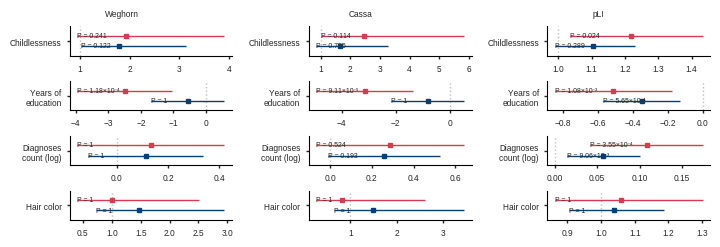

In [18]:
cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 6*cm*k))

subfigs = fig.subfigures(nrows=1, ncols=3, width_ratios=[ 1, 1, 1], wspace=0.03)

plot_id_vs_rest_subfig(subfigs[0], 'Weghorn')
subfigs[0].suptitle('Weghorn', fontsize=plotting.MEDIUM_SIZE)

plot_id_vs_rest_subfig(subfigs[1], 'Cassa')
subfigs[1].suptitle('Cassa', fontsize=plotting.MEDIUM_SIZE)

plot_id_vs_rest_subfig(subfigs[2], 'pLI')
subfigs[2].suptitle('pLI', fontsize=plotting.MEDIUM_SIZE)

plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_4.pdf", format="pdf", bbox_inches="tight")

# Extended figure 5 (CRs)

In [19]:
renaming_dict_gene_sets = {
    'ID-total': 'ID',
    'Skeletal+Craniofacial': 'Skeletal',
    'Derm': 'Dermatologic',
    'Overlaps': 'Multi-system', 
    'Immune_system': 'Immune system',
}

ukb_cr_df = pd.read_csv(f"{tables_folder}/CR.csv", sep='\t').rename(columns={'panel': 'Panel', 'CR': 'Consaguinity ratio'})
ukb_cr_df['Cohort'] = 'UKB'

ukb_cr_df = ukb_cr_df[['Panel', 'Cohort', 'Consaguinity ratio']]
ukb_cr_df['Consaguinity ratio'] = ukb_cr_df['Consaguinity ratio'].astype(int)
ukb_cr_df['Panel'] = ukb_cr_df['Panel'].apply(lambda x: renaming_dict_gene_sets.get(x, x))
ukb_cr_df

Panel Cohort  Consaguinity ratio
0     Hematologic    UKB                 123
1   Neuromuscular    UKB                  77
2              ID    UKB                  66
3        Skeletal    UKB                  60
4    Cilia+Kidney    UKB                  41
5    Metabolic-ID    UKB                  33
6    Dermatologic    UKB                  33
7    Multi-system    UKB                  28
8       Blindness    UKB                  28
9   Immune system    UKB                  20
10      Endocrine    UKB                  18
11       Deafness    UKB                  15
12      Metabolic    UKB                   9

In [20]:
cr_df = pd.read_csv(f"{tables_folder}/CR_dutch_estonian.csv").melt(id_vars='Panel', value_vars=['UKB', 'Dutch', 'Estonian']).rename(
    columns={'variable': 'Cohort', 'value': 'Consaguinity ratio'})

cr_df = cr_df[cr_df['Panel'] != 'Severe genes']
cr_df = pd.concat([ ukb_cr_df, cr_df[cr_df['Cohort'] != 'UKB'],])
cr_df = cr_df.sort_values(by='Consaguinity ratio', ascending=False)
cr_df.head(3)

Panel    Cohort  Consaguinity ratio
0   Hematologic       UKB                 123
15     Skeletal     Dutch                 123
30     Skeletal  Estonian                  92

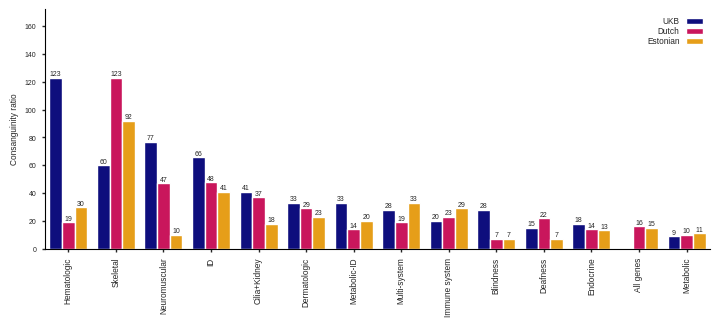

In [21]:
cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 8*cm*k))

ax = fig.subplots(1, 1)

colors = ['#00008b', '#df0057', '#ffa600']

sns.barplot(data=cr_df, x='Panel', y='Consaguinity ratio', hue='Cohort', ax=ax, palette=colors, saturation=0.8)

for container in ax.containers:
    ax.bar_label(container, size=plotting.SMALL_SIZE)

# ax.grid(linestyle='dotted', axis='y') 
plotting.configure_axis(ax, x_label=None, y_label='Consanguinity ratio', ytick_size=plotting.SMALL_SIZE)

plt.xticks(rotation=90)
plt.xlabel(None)

legend_kwargs = {
        "frameon": False,
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }

plt.legend(**legend_kwargs)

# save figure
plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_5.pdf", format="pdf", bbox_inches="tight")

# Extended figure 6 (UKB-Dutch CR correlation)

In [22]:
# read dutch AF
dutch_af = pd.read_csv(f"{tables_folder}/dutch_cohort_average_af.csv")
dutch_af['panel'] = dutch_af['Gene set'].apply(lambda x: x.split()[0])
dutch_af = dutch_af.rename(columns={'Average AF Dutch cohort': 'Dutch cohort AF'})[['panel', 'Dutch cohort AF']]

dutch_af.head(2)

panel  Dutch cohort AF
0     Skeletal         0.000157
1  Hematologic         0.000591

In [23]:
renaming_dict_gene_sets = {
    'Derm': 'Dermatologic',
	'ID-total': 'ID',
	'Immune_system': 'Immune',
	'Overlaps': 'Multi-system',
	'Skeletal+Craniofacial': 'Skeletal'
}

n_samples = 378751

# gene panel
gene_panel = pd.read_csv(".../450k/regions/gene-panel-gencode-v34.txt", header=None)
gene_panel.columns = ['gene', 'panel']

# read plps
plps = ".../450k/plp_selection/basic/new_gene_names/new_freq/new_relatedness/all_chr_total_presumable_plps_HFE_final_sorted.txt"

plps = pd.read_csv(plps, sep='\t')

# merhe with gene panel info
plps = plps.merge(gene_panel, how='inner', on='gene')
plps['panel'] = plps['panel'].apply(lambda x: renaming_dict_gene_sets.get(x, x))

# average over gene
ukbb_af = plps.groupby(['panel', 'gene'])[['hets', 'homs']].sum().reset_index()
ukbb_af['UK Biobank AF'] = (ukbb_af['hets'] + 2*ukbb_af['homs']) / (2*n_samples)

# average over panel
ukbb_af = ukbb_af.groupby('panel')['UK Biobank AF'].mean().reset_index()
ukbb_af.head(2)

panel  UK Biobank AF
0       Blindness       0.000498
1  Cardiovascular       0.000451

In [24]:
af_df = ukbb_af.merge(dutch_af, how='inner',)

af_df

panel  UK Biobank AF  Dutch cohort AF
0       Blindness       0.000498         0.000518
1    Cilia+Kidney       0.000487         0.000541
2        Deafness       0.000971         0.000910
3    Dermatologic       0.000453         0.000557
4       Endocrine       0.000587         0.000533
5     Hematologic       0.000257         0.000591
6              ID       0.000355         0.000398
7          Immune       0.000384         0.000297
8       Metabolic       0.000885         0.000646
9    Metabolic-ID       0.000447         0.000594
10   Multi-system       0.000521         0.000556
11  Neuromuscular       0.000279         0.000380
12       Skeletal       0.000216         0.000157

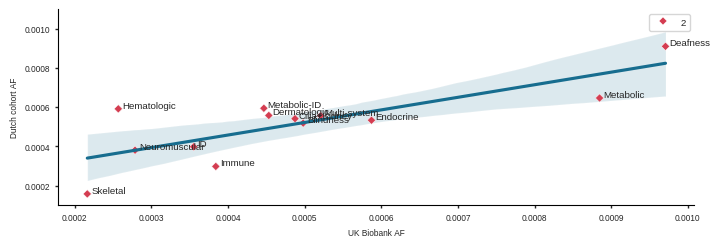

In [25]:
import matplotlib.ticker as ticker

cm = 1/2.54  # centimeters in inches
k = 1.

fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 6*cm*k))
ax = fig.subplots(1, 1)

colors = [ "#de6069", "#49829f"]


sns.regplot(data=af_df, x='UK Biobank AF', y='Dutch cohort AF', marker='D',  scatter_kws={"color": "#d43d51", 's':2}, color="#176d8f", ax=ax)

sns.scatterplot(data=af_df, x='UK Biobank AF', y='Dutch cohort AF', marker='D', size=2, color='#d43d51', ax=ax)

# sns.lineplot(x=[0, 0.001], y=[0, 0.001], color='gray', linestyle='--')
for row in af_df.values:
    gene_set, ukb_af, dutch_af = tuple(row)
    plt.annotate(gene_set, (ukb_af+0.000005,  dutch_af+0.000005))

plotting.configure_axis(ax, x_label='UK Biobank AF', y_label='Dutch cohort AF', format_x=False, format_y=False, ylim=[0.0001, 0.0011])

# save figure
plt.savefig(f"{PLOTS_OUTPUT_DIR}/ext_figure_6.pdf", format="pdf", bbox_inches="tight")

In [26]:
from scipy.stats import pearsonr

corr = pearsonr(af_df['UK Biobank AF'].values, af_df['Dutch cohort AF'].values)

print (corr)
print (corr.confidence_interval(0.95))

PearsonRResult(statistic=np.float64(0.7908218733021452), pvalue=np.float64(0.0012870426944499036))
ConfidenceInterval(low=np.float64(0.4250395972083317), high=np.float64(0.934581033343889))


In [27]:
!ls -lah $PLOTS_OUTPUT_DIR

total 656K
drwxrwx--- 2 gelana bioinf 204 Mar  6 16:52 .
drwxrwx--- 4 gelana bioinf 396 Mar  6 16:19 ..
-rwxrwx--- 1 gelana bioinf 14K Mar  6 16:26 ext_figure_1.pdf
-rwxrwx--- 1 gelana bioinf 14K Mar  6 16:31 ext_figure_2.pdf
-rwxrwx--- 1 gelana bioinf 15K Mar  6 16:36 ext_figure_3.pdf
-rwxrwx--- 1 gelana bioinf 14K Mar  6 16:46 ext_figure_4.pdf
-rwxrwx--- 1 gelana bioinf 13K Mar  6 16:50 ext_figure_5.pdf
-rwxrwx--- 1 gelana bioinf 15K Mar  6 16:52 ext_figure_6.pdf


## S-het comparison: AR/AD and AD genes

In [6]:
s_het = pd.read_csv(".../450k/selection_roulette/s_het_roulette_gencode-v34.csv", sep='\t')


#gene panel
gene_panel = pd.read_csv(".../450k/regions/gene-panel-gencode-v34.txt", header=None)
gene_panel.columns = ['Gene name', 'Gene panel']

ADAR_genes = pd.read_csv('.../450k/regions/ADAR_genes_gencode-v34.txt', header=None)[0].values.tolist()

gene_panel['effect'] = 'AR'
gene_panel.loc[gene_panel['Gene name'].isin(ADAR_genes), 'effect'] = 'AD/AR'

gene_panel['is_ID'] = gene_panel['Gene panel'] == 'ID-total'
gene_panel['is_ADAR'] = gene_panel['effect'] == 'AD/AR'


gene_panel = gene_panel.merge(s_het, left_on='Gene name', right_on='gene_symbol', how='left')

gene_panel.effect.value_counts()

effect
AR       1605
AD/AR     324
Name: count, dtype: int64

In [14]:
from scipy.stats import permutation_test
shet_scores_AD_AR = gene_panel[gene_panel['effect'] == 'AD/AR']['s_het'].dropna()
shet_scores_AR = gene_panel[gene_panel['effect'] == 'AR']['s_het'].dropna()

# Perform a permutation test with 10,000 resamples
perm_test_result = permutation_test((shet_scores_AD_AR, shet_scores_AR), 
                                    statistic=lambda x, y: np.mean(x) - np.mean(y), 
                                    permutation_type='independent', 
                                    n_resamples=10000)

# Print results
print(f"Permutation test statistic: {perm_test_result.statistic:.4f}")
print(f"P-value: {perm_test_result.pvalue:.3f}")


Permutation test statistic: -0.0012
P-value: 0.716
